# TUTORIAL: Speech to text - Compare some models

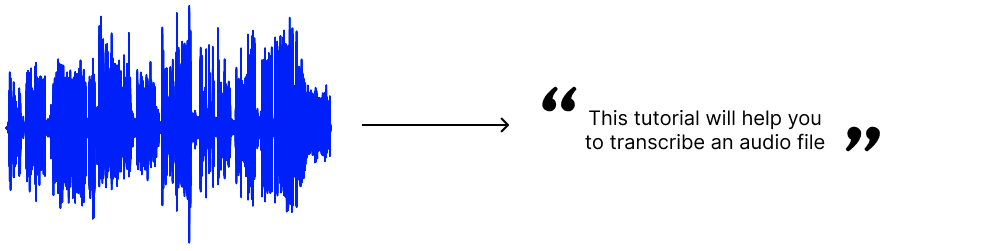

## Introduction

This notebook is the third of a series of tutorials. We strongly recommend you to **read the first episode [Speech to text - Basics]** before doing this one, since we will use functions defined and explained in the previous episode. 

## Objective

The different steps of this third tutorial are as follow:

- Set up environment
- Load pre-trained models
- Transcribe some audios
- Analyze results

## Going further

**Next tutorial** will show you how to:

- Build a complete speech to text application to make your code interactive.

## Step 1 - Set up environment

*This notebook has been created on **AI Notebooks** with the `conda-py39-cuda11.2-v22-4" image.`*

### A - Install and import dependencies

As the first step, let's set up the structure of our project. Several librairies need to be installed and imported. 

In [ ]:
!pip install -r requirements.txt

In [2]:
# Manipulate sound
import audioread
import librosa
from pydub import AudioSegment, silence

# Load models & metrics to evaluate results
from transformers import Wav2Vec2Tokenizer, Wav2Vec2ForCTC, Wav2Vec2Processor, HubertForCTC
import torch
from torchmetrics import WordErrorRate

# Data visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np
import pandas as pd

# Others (Text & time process, system navigation, ...)
import requests
import os
import time

### B - Create a folder to temporarily save the sounds we transcribe

In [3]:
dir_path = "/workspace/audio_chunks" 
if not os.path.exists(dir_path):
    os.makedirs(dir_path)

### C - Import code from previous tutorial

> #### All this code has been explained in the previous tutorials. Its usefulness will therefore not be re-explained here. 
>
> Refer to this [GitHub repository](https://github.com/ovh/ai-training-examples/tree/main/notebooks/natural-language-processing/speech-to-text/conda).

Only the first function below, named `transcribe_audio_part()`, has been reviewed so it can handle different types of models.

In [3]:
def transcribe_audio_part(models_list, execution_times_list, transcripts_list, filename, myaudio, sub_start, sub_end, index):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    number_of_models = len(models_list)
    
    try:
        new_audio = myaudio[sub_start:sub_end]  # Works in milliseconds
        path = "/workspace/audio_chunks/" + filename[:-3] + str(index) + ".wav"
        new_audio.export(path)  # Exports to a mp3 file in the current path.
        
        # Load audio file with librosa, set sound rate to 16000 Hz because the model we use was trained on 16000 Hz data.
        input_audio, _ = librosa.load(path, sr=16000)
        
        for model_counter in range (number_of_models):
            start_time = time.time()
            with torch.no_grad():
                # return PyTorch torch.Tensor instead of a list of python integers thanks to return_tensors = ‘pt’
                input_values = models_list[model_counter][1](input_audio, sampling_rate=16000, return_tensors="pt").to(device).input_values  
                
                # Get logits from the data structure containing all the information returned by the model and get our prediction
                logits = models_list[model_counter][0].to(device)(input_values).logits
                prediction = torch.argmax(logits, dim=-1)
            
            # Decode & add to our caption string
            if isinstance(models_list[model_counter][1], Wav2Vec2Tokenizer):
                transcript = models_list[model_counter][1].batch_decode(prediction)[0]
                end_time = time.time()
                transcripts_list[model_counter] += transcript.lower() + " "
                execution_times_list[model_counter] += round(end_time - start_time, 2)
                
            elif isinstance(models_list[model_counter][1], Wav2Vec2Processor):
                transcript = models_list[model_counter][1].decode(prediction[0])
                end_time = time.time()
                transcripts_list[model_counter] += transcript.lower() + " "
                execution_times_list[model_counter] += round(end_time - start_time, 2)
                
            else:
                print("Type not recognized: ", type(processor_or_tokenizer)) 
                
        # Clean audio_chunks folder
        for file in os.listdir("/workspace/audio_chunks"):
            os.remove(os.path.join("/workspace/audio_chunks", file))
    
    except audioread.NoBackendError:
        # Means we have a chunk with a [value1 : value2] case with value1>value2
        print("Sorry, seems we have a problem on our side. Please change start & end values.")
        
        # Stop 
        exit()

In [4]:
def detect_silences(audio):
    # Get Decibels (dB) so silences detection depends on the audio instead of a fixed value
    dbfs = audio.dBFS
    
    # Get silences timestamps > 750ms 
    silence_list = silence.detect_silence(audio, min_silence_len=750, silence_thresh=dbfs-14)
    return silence_list

In [5]:
def get_middle_values(silence_list):
    # Replace timestamps by their middle value
    new_silence_list=[]
    for timestamp in silence_list:
        new_silence_list.append(timestamp[0]+(timestamp[1]-timestamp[0])/2)
    return new_silence_list

In [6]:
def silences_distribution(silence_list, min_space, max_space, start, end, srt_token=False):
    """
    We keep each silence value if it is sufficiently distant from its neighboring values, without being too much
    :param silence_list: List with silences intervals
    :param min_space: Minimum temporal distance between two silences
    :param max_space: Maximum temporal distance between two silences
    :param start: int value (seconds)
    :param end: int value (seconds)
    :param srt_token: Enable/Disable generate srt file (choice fixed by user)
    :return: list with equally distributed silences
    """
    # If starts != 0, we need to adjust end value since silence detection is performed on the cropped audio (and not on the original audio)

    # Shift the end according to the start value
    end -= start
    start = 0
    end *= 1000

    # Step 1 - Adding start value
    newsilence = [start]

    # Step 2 - Create a regular distribution between start and the first element of silence_list to don't have a gap > max_space and run out of memory
    # example newsilence = [0] and silence_list starts with 100000 => It will create a massive gap [0, 100000]

    if silence_list[0] - max_space > newsilence[0]:
        for i in range(int(newsilence[0]), int(silence_list[0]), max_space):  # int bc float can't be in a range loop
            value = i + max_space
            if value < silence_list[0]:
                newsilence.append(value)

    # Step 3 - Create a regular distribution until the last value of the silence_list
    min_desired_value = newsilence[-1]
    max_desired_value = newsilence[-1]
    nb_values = len(silence_list)

    while nb_values != 0:
        max_desired_value += max_space

        # Get a window of the values greater than min_desired_value and lower than max_desired_value
        silence_window = list(filter(lambda x: min_desired_value < x <= max_desired_value, silence_list))

        if silence_window != []:
            # Get the nearest value we can to min_desired_value or max_desired_value depending on srt_token
            if srt_token:
                nearest_value = min(silence_window, key=lambda x: abs(x - min_desired_value))
                nb_values -= silence_window.index(nearest_value) + 1  # (index begins at 0, so we add 1)
            else:
                nearest_value = min(silence_window, key=lambda x: abs(x - max_desired_value))
                # Max value index = len of the list
                nb_values -= len(silence_window)

            # Append the nearest value to our list
            newsilence.append(nearest_value)

        # If silence_window is empty we add the max_space value to the last one to create an automatic cut and avoid multiple audio cutting
        else:
            newsilence.append(newsilence[-1] + max_space)

        min_desired_value = newsilence[-1]
        max_desired_value = newsilence[-1]

    # Step 4 - Add the final value (end)

    if end - newsilence[-1] > min_space:
        # Gap > Min Space
        if end - newsilence[-1] < max_space:
            newsilence.append(end)
        else:
            # Gap too important between the last list value and the end value
            # We need to create automatic max_space cut till the end
            newsilence = generate_regular_split_till_end(newsilence, end, min_space, max_space)
    else:
        # Gap < Min Space <=> Final value and last value of new silence are too close, need to merge
        if len(newsilence) >= 2:
            if end - newsilence[-2] <= max_space:
                # Replace if gap is not too important
                newsilence[-1] = end
            else:
                newsilence.append(end)

        else:
            if end - newsilence[-1] <= max_space:
                # Replace if gap is not too important
                newsilence[-1] = end
            else:
                newsilence.append(end)

    return newsilence

In [7]:
def generate_regular_split_till_end(time_list, end, min_space, max_space):
    """
    Add automatic "time cuts" to time_list till end value depending on min_space and max_space value
    :param time_list: silence time list
    :param end: int value (s)
    :param min_space: Minimum temporal distance between two silences
    :param max_space: Maximum temporal distance between two silences
    :return: list with automatic time cuts
    """
    # In range Loop can't handle float values so we convert to int
    int_last_value = int(time_list[-1])
    int_end = int(end)
    
    # Add maxspace to the last list value and add this value to the list
    for i in range(int_last_value, int_end, max_space):
        value = i + max_space
        if value < end:
            time_list.append(value)

    # Fix last automatic cut
    # If small gap (395 000, with end = 400 000)
    if end - time_list[-1] < min_space:
        time_list[-1] = end
    else:
        # Important gap (ex: 311 000 then 356 000, with end = 400 000, can't replace and then have 311k to 400k)
        time_list.append(end)
    return time_list

In [8]:
def download_audio_file(url, filename, folder="sounds/"):
    # Download audio file
    filename = folder + filename

    response = requests.get(url)
    if response.status_code == 200:
        with open(filename, "wb") as file:
            file.write(response.content)
        print(f"File '{filename}' downloaded successfully!")
    else:
        print("Failed to download the file.")

## Step 2: Load pre-trained models

This time, we are not going to only import the base 960h Wav2Vec2 model. Indeed, I showed you this version because it is the most popular one on the **[Hugging Face website](https://huggingface.co/models)**, but there are plenty more available! 

Since the base 960h is the most popular version, we can ask ourselves if that means this is the best one? The fastest? The most qualitative? 

To answer this question, we are going to **load different pre-trained models** from Hugging Face. Then, we will use each of them to transcribe the same audio files and we will **compare the results** thanks to **WER (word error rate)** metric, seen in first tutorial and the **time it takes to obtain the transcript**. 

> ⚠️ Keep in mind that messages in red may appear throughout the execution of the code.
>
> Do not worry, these warnings do not disturb the execution of the code.

### A - Create lists to save models and their names

First, create two lists. The first one will save each loaded models while we will only add their names as strings in the second one.

In [8]:
models_list = []
models_names_list = []

Then, we can load 7 different speech to text pre-trained models. 

For each model, we will specify its **respective rank** according to the number of downloads on the Hugging Face website as well as the **datasets** on which the model has been trained.

Here is a definition of each of the datasets mentioned: 
- **CommonVoice**: crowd-source collected audio data (read-out text snippets) [Clean]
- **Fisher**: conversational telephone speech [Noisy]
- **Libri-Light**: open-source audio books from the LibriVox project [Clean]
- **LibriSpeech**: open-source read-out audio data. [Clean]
- **Switchboard**: telephone speech corpus [Noisy]

### B.1 - Load Base 960h Wav2Vec2

**Rank** : #1
<br>**Train** : 960 hours of Librispeech

In [ ]:
model_name = "facebook/wav2vec2-base-960h"
model = Wav2Vec2ForCTC.from_pretrained(model_name)
tokenizer = Wav2Vec2Tokenizer.from_pretrained(model_name)

# Add model to lists
if [model, tokenizer] not in models_list:
    models_list.append([model, tokenizer])
    models_names_list.append(model_name)

> Do no worry about red messages.

### B.2 - Load hubert large ls960 fine tuned Model

**Rank** : #2
<br>**Train** : 960 hours of Librispeech

In [10]:
model_name = "facebook/hubert-large-ls960-ft"
model = HubertForCTC.from_pretrained(model_name)
processor = Wav2Vec2Processor.from_pretrained(model_name)

# Add model to list
if [model, processor] not in models_list:
    models_list.append([model, processor])
    models_names_list.append(model_name)

### B.3 - Load Large 960h Wav2Vec2

**Rank** : #3
<br>**Train** : 960 hours of Librispeech

In [ ]:
model_name = "facebook/wav2vec2-large-960h"
model = Wav2Vec2ForCTC.from_pretrained(model_name)
processor = Wav2Vec2Processor.from_pretrained(model_name)

# Add model to list
if [model, processor] not in models_list:
    models_list.append([model, processor])
    models_names_list.append(model_name)


### B.4 - Load Large 960h Lv60 Wav2Vec2 + Self-Training 
**Rank** : #6
<br>**Train** : 960 hours of Libri-Light and Librispeech

In [ ]:
model_name = "facebook/wav2vec2-large-960h-lv60-self"
model = Wav2Vec2ForCTC.from_pretrained(model_name)
processor = Wav2Vec2Processor.from_pretrained(model_name)

# Add model to list
if [model, processor] not in models_list:
    models_list.append([model, processor])
    models_names_list.append(model_name)

### B.5 - Load Large robust Wav2Vec2

**Rank**: #3400
<br>**Train** : Libri-Light, CommonVoice, Switchboard, Fisher and finetuned on 960 hours of Librispeech

In [13]:
model_name = "facebook/wav2vec2-large-robust-ft-libri-960h"
model = Wav2Vec2ForCTC.from_pretrained(model_name)
processor = Wav2Vec2Processor.from_pretrained(model_name)

# Add model to list
if [model, processor] not in models_list:
    models_list.append([model, processor])
    models_names_list.append(model_name)

### B.6 - Large 960 lvl 60 Wav2Vec2

**Rank** : #436
<br>**Train** : pre-trained and fine-tuned on 960 hours of Libri-Light and Librispeech

In [ ]:
model_name = "facebook/wav2vec2-large-960h-lv60"

model = Wav2Vec2ForCTC.from_pretrained(model_name)
processor = Wav2Vec2Processor.from_pretrained(model_name)

# Add model to list
if [model, processor] not in models_list:
    models_list.append([model, processor])
    models_names_list.append(model_name)

### B.7 - Base 100h Wav2Vec2

**Rank** : #2839
<br>**Train** : Unknown

In [15]:
model_name = "patrickvonplaten/wav2vec2-base-100h-with-lm"

model = Wav2Vec2ForCTC.from_pretrained(model_name)
processor = Wav2Vec2Processor.from_pretrained(model_name)

# Add model to list
if [model, processor] not in models_list:
    models_list.append([model, processor])
    models_names_list.append(model_name)

### B.8 Verify all the models have been well loaded

In [16]:
print("We should have 7 models in the list. Currently, there are : ")
print(len(models_list))

We should have 7 models in the list. Currently, there are : 
7


### C - Create lists to save our results

We will compare the **execution time** of the transcription process and the **transcripts** ! They need to be saved in two lists :

In [17]:
number_of_models = len(models_list)

execution_times_list = [0 for i in range(number_of_models)]
transcripts_list = ["" for i in range(number_of_models)]

## Step 3 - Transcribe some audios 

Now we will use the loaded models to transcribe text with silence method detection.

First, let's try with the [audio recording](https://ia800504.us.archive.org/14/items/childrens_shakespeare_1010_librivox/thechildrensshakespeare_04_nesbit.mp3) of the *King Lear* book from the first tutorial (book written by *Edith Nesbit (1858 - 1924)*, read by *Elizabeth Klett* on [LibriVox website](https://librivox.org/).

### A - Read-out audio book - The King Lear

Download & load the audio file, and apply silence method detection to it:

In [9]:
# Download audio file
download_audio_file("https://ia902709.us.archive.org/4/items/childrens_shakespeare_1010_librivox/thechildrensshakespeare_04_nesbit.mp3", filename="thechildrensshakespeare_04_nesbit.mp3", folder="sounds/")

File 'sounds/thechildrensshakespeare_04_nesbit.mp3' downloaded successfully!


In [18]:
king_lear_audio = AudioSegment.from_file("sounds/thechildrensshakespeare_04_nesbit.mp3")

# detect silences and silences treatment
silence_list = detect_silences(king_lear_audio)
silence_list = get_middle_values(silence_list)
silence_list = silences_distribution(silence_list, min_space=25000, max_space=45000, start=0, end=king_lear_audio.duration_seconds)

Then we can transcribe the audio file:

In [ ]:
transcript = ""
for i in range(0, len(silence_list) - 1):
    sub_start = silence_list[i]
    sub_end = silence_list[i + 1]
    
    transcribe_audio_part(models_list, execution_times_list, transcripts_list, "thechildrensshakespeare_04_nesbit.mp3", king_lear_audio, sub_start, sub_end, i)

> ⚠️ As usual, red messages may appear here since we use the librosa library to load our audio files. You'll get plenty here since the audio is 10 minutes long. Do not worry about it.

### Display results in a DataFrame to easily compare results

> A **DataFrame** is a data structure that organizes data into a 2-dimensional table of rows and columns, much like a spreadsheet. It allows us to visualize our data easily.

In [20]:
# Create the DataFrame with a column equals to the names of the models
df=pd.DataFrame(data = models_names_list, columns=['Model'])

# Add transcript & execution time lists to our DataFrame
df = df.assign(Transcript=transcripts_list, Time1=execution_times_list)

# Display the data
display(df)

,Model,Transcript,Time1
0,facebook/wav2vec2-base-960h,chapter four of the children shakespeare this ...,7.74
1,facebook/hubert-large-ls960-ft,chapter four of the children shakespeare this ...,4.23
2,facebook/wav2vec2-large-960h,chapter four of the children shakespeare this ...,3.83
3,facebook/wav2vec2-large-960h-lv60-self,chapter four of the children shakespeare this ...,4.18
4,facebook/wav2vec2-large-robust-ft-libri-960h,chapter four of the children' shakespeare this...,4.37
5,facebook/wav2vec2-large-960h-lv60,chapter four of the children shakespeare this ...,4.23
6,patrickvonplaten/wav2vec2-base-100h-with-lm,chapter four of the children' shakespeare this...,1.67


As you see, DataFrame makes it possible to quickly visualize data. However, there is a metric that we miss, the **WER**

⚠️ Keep in mind that execution time here only measures the speed of transcribing action and does not take into account other elements like the loading time of each audio chunk. That's why it is a very short time compared to the total times it takes (need also to load the audio, save WER and execution time, ...) 

### Calculate and add transcript’s WER to the DataFrame

As we saw in the first episode, **WER measures the quality of the transcript**. If we compare each obtained transcript with the real one, we can try to **identify the best performing model** by looking at the WER.

⚠️ As **WER counts errors**, keep in mind that **the lower its value, the better the transcript**. 

In [21]:
# Load metric
metric = WordErrorRate()

# Real transcript
real_text = """chapter four of the children's shakespeare this is a librivox recording all librivox recordings are in the public domain for more information or to volunteer please visit librivox dot org recording by elizabeth klett the children's shakespeare by edith nesbit chapter four king lear king lear was old and tired he was aweary of the business of his kingdom and wished only to end his days quietly near his three daughters whom he loved dearly two of his daughters were married to the dukes of albany and cornwall and the duke of burgundy and the king of france were both staying at lear’s court as suitors for the hand of cordelia his youngest daughter lear called his three daughters together and told them that he proposed to divide his kingdom between them but first said he i should like to know how much you love me goneril who was really a very wicked woman and did not love her father at all said she loved him more than words could say she loved him dearer than eyesight space or liberty more than life grace health beauty and honor if you love me as much as this said the king i give you a third part of my kingdom and how much does regan love me i love you as much as my sister and more professed regan since i care for nothing but my father’s love lear was very much pleased with regan’s professions and gave her another third part of his fair kingdom then he turned to his youngest daughter cordelia now our joy though last not least he said the best part of my kingdom have i kept for you what can you say nothing my lord answered cordelia nothing nothing said cordelia nothing can come of nothing speak again said the king and cordelia answered i love your majesty according to my duty no more no less and this she said because she knew her sisters’ wicked hearts and was disgusted with the way in which they professed un bounded and impossible love when really they had not even a right sense of duty to their old father i am your daughter she went on and you have brought me up and loved me and i return you those duties back as are right fit obey you love you and most honor you lear who loved cordelia best had wished her to make more extravagant professions of love than her sisters and what seemed to him her coldness so angered him that he bade her begone from his sight go he said be for ever a stranger to my heart and me the earl of kent one of lear's favorite courtiers and captains tried to say a word for cordelia's sake but lear would not listen he divided the remaining part of his kingdom between goneril and regan who had pleased him with their foolish flattery and told them that he should only keep a hundred knights at arms for his following and would live with his daughters by turns when the duke of burgundy knew that cordelia would have no share of the kingdom he gave up his courtship of her but the king of france was wiser and said to her fairest cordelia thou art most rich being poor most choice forsaken and most loved despised thee and thy virtues here i seize upon thy dowerless daughter king is queen of us of ours and our fair france take her take her said the king for i have no such daughter and will never see that face of hers again so cordelia became queen of france and the earl of kent for having ventured to take her part was banished from the king's court and from the kingdom the king now went to stay with his daughter goneril and very soon began to find out how much fair words were worth she had got everything from her father that he had to give and she began to grudge even the hundred knights that he had reserved for himself she frowned at him whenever she met him she herself was harsh and undutiful to him and her servants treated him with neglect and either refused to obey his orders or pretended that they did not hear them now the earl of kent when he was banished made as though he would go into another country but instead he came back in the disguise as a serving-man and took service with the king who never suspected him to be that earl of kent whom he himself had banished the very same day that lear engaged him as his servant goneril’s steward insulted the king and the earl of kent showed his respect for the king’s majesty by tripping up the caitiff into the gutter the king had now two friends the earl of kent whom he only knew as his servant and his fool who was faithful to him although he had given away his kingdom general was not contented with letting her father suffer insults at the hands of her servants she told him plainly that his train of one hundred knights only served to fill her court with riot and feasting and so she begged him to dismiss them and only keep a few old men about him such as himself my train are men who know all parts of duty said lear saddle my horses call my train together goneril i will not trouble you further yet i have left another daughter and he cursed his daughter goneril praying that she might never have a child or that if she had it might treat her as cruelly as she had treated him and his horses being saddled he set out with his followers for the castle of regan his other daughter lear sent on his servant caius who was really the earl of kent with letters to his daughter to say he was coming but caius fell in with a messenger of goneril in fact that very steward whom he had tripped into the gutter and beat him soundly for the mischief-maker that he was and regan when she heard it put caius in the stocks not respecting him as a messenger coming from her father and she who had formerly outdone her sister in professions of attachment to the king now seemed to outdo her in undutiful conduct saying that fifty knights were too many to wait on him that five-and-twenty were enough and gonerit who had hurried thither to prevent regan showing any kindness to the old king said five-and-twenty were too many or even ten or even five since her servants could wait on him what need one said regan then when lear saw that what they really wanted was to drive him away from them he cursed them both and left them it was a wild and stormy night yet those cruel daughters did not care what became of their father in the cold and the rain but they shut the castle doors and went in out of the storm all night he wandered about the heath half mad with misery and with no companion but the poor fool but presently his servant caius the good earl of kent met him and at last persuaded him to lie down in a wretched little hovel which stood upon the heath at daybreak the earl of keilt removed his royal master to dover where his old friends were and then hurried to the court of france and told cordelia what had happened her husband gave her an army to go to the assistance of her father and with it she landed at dover here she found poor king lear now quite mad wandering about the fields sineing aloud to himself and wearing a crown of nettles and weeds thev brought him back and fed and clothed him and the doctors gave him such medicines as they thought might bring him back to his right mind and by-and-by he woke better but still not quite himself then cordelia came to him and kissed him to make up as she said foi her sisters at first he hardly knew her pray do not mock me' he said /i am a very foolish fond old man four-score and upward and to deal plainly i fear i am not in my perfect mind i think i should know you though i do not know these garments nor do i know where i lodged last night do not laugh at me though as i am a man i think this lady must be my daughter cordelia and so i am i am cried cordelia come with me you must bear with me said lear forget and forgive i am old and foolish and now he knew at last which of his children it was that had loved him best and who was worthy of his love; and from that time they were not parted goneril and regan joined their armies to fight cordelia's army and were successful and cordelia and her father were thrown into prison then goneril's husband the duke of albany who was a good man and had not known how wicked his wife was heard the truth of the whole story and when goneril found that her husband knew her for the wicked woman she was she killed herself having a little time before given a deadly poison to her sister regan out of a spirit of jealousy but they had arranged that cordelia should be hanged in prison and though the duke of albany sent messengers at once it was too late the old king came staggering into the tent of the duke of albany carrying the body of his dear daughter cordelia in his arms it oh she is gone for ever he said i know when one is dead and when one lives she's dead as earth they crowded round in horror oh if she lives said the king it is a chance that does redeem all sorrows that ever i have left the earl of kent spoke a word to him but lear was too mad to listen a plague upon you murderous traitors all i might have saved her now she is gone for ever cordelia cordelia stay a little her voice was ever low gentle and soft an excellent thing in woman i killed the slave that was hanging thee tis true my lords he did said one of the officers from the castle oh thou wilt come no more cried the poor old man do you see this look on her look her lips look there look there and with that he fell with her still in his arms and died and this was the end of lear and cordelia end of chapter four """

# Create a list to save WERs
wer_score = []

# Calculate and save all WERs in a list
for elt in transcripts_list:
    wer_score.append(round(metric(elt, real_text).item()*100, 2))

We have the WER or each transcript. Now, let's add WERs as a new column to the DataFrame !

In [22]:
df = df.assign(WER1=wer_score)
display(df)

,Model,Transcript,Time1,WER1
0,facebook/wav2vec2-base-960h,chapter four of the children shakespeare this ...,7.74,5.12
1,facebook/hubert-large-ls960-ft,chapter four of the children shakespeare this ...,4.23,4.13
2,facebook/wav2vec2-large-960h,chapter four of the children shakespeare this ...,3.83,4.68
3,facebook/wav2vec2-large-960h-lv60-self,chapter four of the children shakespeare this ...,4.18,2.92
4,facebook/wav2vec2-large-robust-ft-libri-960h,chapter four of the children' shakespeare this...,4.37,4.13
5,facebook/wav2vec2-large-960h-lv60,chapter four of the children shakespeare this ...,4.23,3.52
6,patrickvonplaten/wav2vec2-base-100h-with-lm,chapter four of the children' shakespeare this...,1.67,6.60


Here, all the WERs are very good (lower than 7). This can be explained by the accent of the speaker but also the nature of the audio which is reading a book. Indeed, this makes the words more articulate than if it were a normal conversation. 

Also, we can note that the model that takes the longest time does not necessarily generate the best transcript.

To analyze these 2 metrics and find the best model, it is simpler to have a single value which is the **ratio** of these values. Let's calculate it and add it to our DataFrame :

### Calculate the ratio of time by WER

In [23]:
# Calculate ratio of column "Time1" by "WER1" and add it to the DataFrame as "Ratio1"
df['Ratio1'] = df['Time1']/df['WER1']
display(df)

,Model,Transcript,Time1,WER1,Ratio1
0,facebook/wav2vec2-base-960h,chapter four of the children shakespeare this ...,7.74,5.12,1.511719
1,facebook/hubert-large-ls960-ft,chapter four of the children shakespeare this ...,4.23,4.13,1.024213
2,facebook/wav2vec2-large-960h,chapter four of the children shakespeare this ...,3.83,4.68,0.818376
3,facebook/wav2vec2-large-960h-lv60-self,chapter four of the children shakespeare this ...,4.18,2.92,1.431507
4,facebook/wav2vec2-large-robust-ft-libri-960h,chapter four of the children' shakespeare this...,4.37,4.13,1.058111
5,facebook/wav2vec2-large-960h-lv60,chapter four of the children shakespeare this ...,4.23,3.52,1.201705
6,patrickvonplaten/wav2vec2-base-100h-with-lm,chapter four of the children' shakespeare this...,1.67,6.60,0.253030


### Sort DataFrame by this ratio to improve the visibility of results

⚠️ The higher ratio, the better the transcript!

In [24]:
display(df.sort_values(by=['Ratio1'], ascending=False))

,Model,Transcript,Time1,WER1,Ratio1
0,facebook/wav2vec2-base-960h,chapter four of the children shakespeare this ...,7.74,5.12,1.511719
3,facebook/wav2vec2-large-960h-lv60-self,chapter four of the children shakespeare this ...,4.18,2.92,1.431507
5,facebook/wav2vec2-large-960h-lv60,chapter four of the children shakespeare this ...,4.23,3.52,1.201705
4,facebook/wav2vec2-large-robust-ft-libri-960h,chapter four of the children' shakespeare this...,4.37,4.13,1.058111
1,facebook/hubert-large-ls960-ft,chapter four of the children shakespeare this ...,4.23,4.13,1.024213
2,facebook/wav2vec2-large-960h,chapter four of the children shakespeare this ...,3.83,4.68,0.818376
6,patrickvonplaten/wav2vec2-base-100h-with-lm,chapter four of the children' shakespeare this...,1.67,6.60,0.253030


An order of performance emerges, but **we must test on other audios** before making any deductions !

### B - Read-out audio book - Oliver Twist

[Audio file](https://ia804504.us.archive.org/28/items/oliver_twist_librivox/dickens_oliver_twist_01_64kb.mp3) from [LibriVox](https://librivox.org/). This file is a read-out by *Stephan Möbius* of *Oliver Twist, Chapter 1*, written by *Charles Dickens (1812 - 1870).*

Download & load the audio file, and apply silence method detection to it :

In [10]:
# Download audio file
download_audio_file("https://ia804504.us.archive.org/28/items/oliver_twist_librivox/dickens_oliver_twist_01_64kb.mp3", filename="dickens_oliver_twist_01_64kb.mp3", folder="sounds/")

File 'sounds/dickens_oliver_twist_01_64kb.mp3' downloaded successfully!


In [25]:
oliver_twist_audio = AudioSegment.from_file("sounds/dickens_oliver_twist_01_64kb.mp3")

# Detect silences and silences treatment
silence_list = detect_silences(oliver_twist_audio)
silence_list = get_middle_values(silence_list)
silence_list = silences_distribution(silence_list, min_space=25000, max_space=45000, start=0, end=oliver_twist_audio.duration_seconds)

Then, transcribe the audio file :

In [ ]:
# Clean lists
execution_times_list = [0 for i in range(number_of_models)]
transcripts_list = ["" for i in range(number_of_models)]

# Transcribe the audio file
transcript = ""
for i in range(0, len(silence_list) - 1):
    sub_start = silence_list[i]
    sub_end = silence_list[i + 1]
    transcribe_audio_part(models_list, execution_times_list, transcripts_list, "dickens_oliver_twist_01_64kb.mp3", oliver_twist_audio, sub_start, sub_end, i)

In [27]:
# Create a new DataFrame with a column equals to the names of the models
df2=pd.DataFrame(data = models_names_list, columns=['Model'])

# Add transcript & execution time lists to our DataFrame
df2 = df2.assign(Transcript=transcripts_list)
df2 = df2.assign(Time2=execution_times_list)

real_text = """this is a librivox recording and all librivox recordings are in the public domain for more information or to volunteer please visit librivox dot org this reading by stephan moblus of oliver twist or the parish boy’s progress by charles dickens chapter one treats of the place where oliver twist was born and of the circumstances attending his birth among other public buildings in a certain town which for many reasons it will be prudent to refrain from mentioning and to which i will assign no fictitious name there is one anciently common to most towns great or small to wit a workhouse and in this workhouse was born on a day and date which i need not trouble myself to repeat inasmuch as it can be of no possible consequence to the reader in this stage of the business at all events the item of mortality whose name is prefixed to the head of this chapter for a long time after it was ushered into this world of sorrow and trouble by the parish surgeon it remained a matter of considerable doubt whether the child would survive to bear any name at all in which case it is somewhat more than probable that these memoirs would never have appeared or if they had that being comprised within a couple of pages they would have possessed the inestimable merit of being the most concise and faithful specimen of biography extant in the literature of any age or country although i am not disposed to maintain that the being born in a workhouse is in itself the most fortunate and enviable circumstance that can possibly befall a human being i do mean to say that in this particular instance it was the best thing for oliver twist that could by possibility have occurred the fact is that there was considerable difficulty in inducing oliver to take upon himself the office of respiration a troublesome practice but one which custom has rendered necessary to our easy existence and for some time he lay gasping on a little flock mattress rather unequally poised between this world and the next the balance being decidedly in favour of the latter now if during this brief period oliver had been surrounded by careful grandmothers anxious aunts experienced nurses and doctors of profound wisdom he would most inevitably and indubitably have been killed in no time there being nobody by however but a pauper old woman who was rendered rather misty by an unwonted allowance of beer and a parish surgeon who did such matters by contract oliver and nature fought out the point between them the result was that after a few struggles oliver breathed sneezed and proceeded to advertise to the inmates of the workhouse the fact of a new burden having been imposed upon the parish by setting up as loud a cry as could reasonably have been expected from a male infant who had not been possessed of that very useful appendage a voice for a much longer space of time than three minutes and a quarter as oliver gave this first proof of the free and proper action of his lungs the patchwork coverlet which was carelessly flung over the iron bedstead rustled the pale face of a young woman was raised feebly from the pillow and a faint voice imperfectly articulated the words let me see the child and die the surgeon had been sitting with his face turned towards the fire giving the palms of his hands a warm and a rub alternately as the young woman spoke he rose and advancing to the bed’s head said with more kindness than might have been expected of him oh you must not talk about dying yet lor bless her dear heart no interposed the nurse hastily depositing in her pocket a green glass bottle the contents of which she had been tasting in a corner with evident satisfaction lor bless her dear heart when she has lived as long as i have sir and had thirteen children of her own and all on ’em dead except two and them in the wurkus with me she’ll know better than to take on in that way bless her dear heart think what it is to be a mother there’s a dear young lamb do apparently this consolatory perspective of a mother’s prospects failed in producing its due effect the patient shook her head and stretched out her hand towards the child the surgeon deposited it in her arms she imprinted her cold white lips passionately on its forehead passed her hands over her face gazed wildly round shuddered fell back and died they chafed her breast hands and temples but the blood had stopped forever they talked of hope and comfort they had been strangers too long it’s all over mrs thingummy said the surgeon at last ah poor dear so it is said the nurse picking up the cork of the green bottle which had fallen out on the pillow as she stooped to take up the child poor dear  you needn’t mind sending up to me if the child cries nurse said the surgeon putting on his gloves with great deliberation it’s very likely it will be troublesome give it a little gruel if it is he put on his hat and pausing by the bed-side on his way to the door added she was a good-looking girl too where did she come from she was brought here last night replied the old woman by the overseer’s order she was found lying in the street she had walked some distance for her shoes were worn to pieces but where she came from or where she was going to nobody knows the surgeon leaned over the body and raised the left hand the old story he said shaking his head no wedding-ring i see ah good-night the medical gentleman walked away to dinner and the nurse having once more applied herself to the green bottle sat down on a low chair before the fire and proceeded to dress the infant what an excellent example of the power of dress young oliver twist was wrapped in the blanket which had hitherto formed his only covering he might have been the child of a nobleman or a beggar it would have been hard for the haughtiest stranger to have assigned him his proper station in society but now that he was enveloped in the old calico robes which had grown yellow in the same service he was badged and ticketed and fell into his place at once a parish child the orphan of a workhouse the humble half-starved drudge to be cuffed and buffeted through the world despised by all and pitied by none oliver cried lustily if he could have known that he was an orphan left to the tender mercies of church-wardens and overseers perhaps he would have cried the louder end of chapter one """

# Calculate and save all WERs in a list
wer_score2 = []
for elt in (transcripts_list):
    wer_score2.append(round(metric(elt, real_text).item()*100, 2))

# Assign wer_score2 list to our DataFrame
df2 = df2.assign(WER2=wer_score2)
df2 = df2.sort_values(by=['WER2']) 

# Calculate ratio of column "Time2" by "WER2" and add it to the DataFrame as "Ratio2"
df2['Ratio2'] = df2['Time2']/df2['WER2']

### Compare results with the first try

In [28]:
# Display the results from the first trial (King lear)
display(df.sort_values(by=['Ratio1'], ascending=False))

# Compare with the second DataFrame
display(df2.sort_values(by=['Ratio2'], ascending=False))

,Model,Transcript,Time1,WER1,Ratio1
0,facebook/wav2vec2-base-960h,chapter four of the children shakespeare this ...,7.74,5.12,1.511719
3,facebook/wav2vec2-large-960h-lv60-self,chapter four of the children shakespeare this ...,4.18,2.92,1.431507
5,facebook/wav2vec2-large-960h-lv60,chapter four of the children shakespeare this ...,4.23,3.52,1.201705
4,facebook/wav2vec2-large-robust-ft-libri-960h,chapter four of the children' shakespeare this...,4.37,4.13,1.058111
1,facebook/hubert-large-ls960-ft,chapter four of the children shakespeare this ...,4.23,4.13,1.024213
2,facebook/wav2vec2-large-960h,chapter four of the children shakespeare this ...,3.83,4.68,0.818376
6,patrickvonplaten/wav2vec2-base-100h-with-lm,chapter four of the children' shakespeare this...,1.67,6.60,0.253030


,Model,Transcript,Time2,WER2,Ratio2
3,facebook/wav2vec2-large-960h-lv60-self,this is a libri vox recording and all libri vo...,2.92,4.99,0.585170
1,facebook/hubert-large-ls960-ft,this is a librevox recording and all librevox ...,2.94,5.16,0.569767
5,facebook/wav2vec2-large-960h-lv60,this is a librivox recording and all librivox ...,2.92,5.16,0.565891
4,facebook/wav2vec2-large-robust-ft-libri-960h,this is a librivox recording and all librivox ...,2.92,5.93,0.492411
2,facebook/wav2vec2-large-960h,this is e liprivolk's recording and all li pri...,2.63,7.57,0.347424
0,facebook/wav2vec2-base-960h,this is a liperavox recording and all liperevo...,1.64,9.46,0.173362
6,patrickvonplaten/wav2vec2-base-100h-with-lm,this is a lipryvox recording and all liprovox ...,1.15,15.48,0.074289


Several observations : 

- The obtained transcripts *(second DataFrame)* are less qualitative than those of the previous trial *(first DataFrame)*. This can be explained by many factors such as the sound quality, the accent of the speaker, ... 
- Also, we notice that the execution time is faster here, which is normal since the audio is shorter (there are fewer words to transcribe). 
- What is mainly interesting is that the order of performance is almost the same as before. 

Now, we need to transcribe more audio files before we can conclude anything.

Let's leave the world of book reading to go into more concrete conversations, where words are less articulated, to see if the order of performance of models is impacted. We will add all the WERs at once to the first DataFrame to conduct a final comparison. 

In [29]:
# Add WER2 and time2 to the first DataFrame
df = df.assign(Time2=execution_times_list)
df = df.assign(WER2=wer_score2)
df['Ratio2'] = df2['Ratio2']

# Transcript column can be removed
df = df.drop(['Transcript'], axis=1)

### C - Audio conversation extract - Make a decision

Audio file from [AMI Corpus](https://groups.inf.ed.ac.uk/ami/corpus/)
<br>Load the audio file and apply silence method detection to it :

In [ ]:
new_audio = AudioSegment.from_file("sounds/IS1009d.Mix-Headset_extract.mp3")

# detect silences and silences treatment
silence_list = detect_silences(new_audio)
silence_list = get_middle_values(silence_list)
silence_list = silences_distribution(silence_list, min_space=25000, max_space=45000, start=0, end=new_audio.duration_seconds)

transcript = ""

# Clean lists
execution_times_list = [0 for i in range(number_of_models)]
transcripts_list = ["" for i in range(number_of_models)]
    
# Transcribe audio file    
for i in range(0, len(silence_list) - 1):
    sub_start = silence_list[i]
    sub_end = silence_list[i + 1]
    
    transcribe_audio_part(models_list, execution_times_list, transcripts_list, "IS1009d.Mix-Headset_extract.mp3", new_audio, sub_start, sub_end, i)

In [31]:
real_text = """well hi everyone again hello hello like before we uh i have to redo the meetings from n th the minutes from the last meeting and so here we go uh it was discussed in the last meeting uh which was opened by the presentation from the interface um designer that uh looks would be very important on this new remote and um it is to send messages of course to the tv it should have nine channel buttons a next button volume buttons subtitle buttons switch to control features colour contrast sharpness etcetera it should have a memory switch a mute button in case the telephone rings or something uh speech recognition is one of her very f favourite personal uh features she would like see d d to be integrated in this um in this new remote um should be child friendly design with few buttons colourful maybe with s star shaped or other shaped buttons um she uh presented also an oversized remote which she guarantees nobody will ever be able to lose um that's right but uh her very f personal favourite really she she would very much like to see a speech recogniser integrated in this remote the industrial designer um presented her uh thoughts on the issue she would like a special case made out of plastic that is very strong not using any harmful materials should be recyclable and should be colourful should have an integrated circuit board that's highly sophisticated and temperature resistant she would like to see a timer and or alarm facility integrated uh technically this thing would also have a resistor and a capacitor diode transistor resonator and if possible a rechargeable battery uh and of course a circuit board and how it would works you press the button the chip is morse morse code related relays the uh to the generat to the generator amplification and uh the circuit board is very inexpensive to build and so she thinks this is a great feature uh to to to consider she would like uh this whole thing should be push buttons with a simple chip uh scrolling method is more expensive and not that practical anymore should be battery operated and of course she would have the special cases the marketing expert uh who has to finally come up with to to to market this product has been watching the competition has done some research on the internet and also has used h her personal observations to come up with the fact that such a remote sh should be small easy to use and it should be eye catching from her point of view of course one of the most important facts is that we should get to market before our competition does to do that uh maybe one or two features should be developed on which we could dwell on or in other words on which our campaign could be built on too many new features or too many points would only confuse matter so we prefer to have one or two features that can be really uh driven home um it should have a fruit and vegetable design and should have a soft feel she feels that's really what people want today and the decision that we took last time was that uh the special feature we would like to see is a speech recogniser the energy should be battery uh should be on a chip should be trendy design compact and strong and should have buttons and that concludes the presentation from the last minutes from the last meeting now uh we are ready for the presentation of the prototype """

# Calculate and save all WERs in a list
wer_score3 = []
for elt in (transcripts_list):
    wer_score3.append(round(metric(elt, real_text).item()*100, 2))

# Add WER3 and Time3 to the first DataFrame
df = df.assign(Time3=execution_times_list)
df = df.assign(WER3=wer_score3)

# Calculate ratio of column "Time3" by "WER3" and add it to the DataFrame as "Ratio3"
df['Ratio3'] = df['Time3']/df['WER3']

### D - Audio conversation extract - Project meeting

Audio file from [AMI Corpus](https://groups.inf.ed.ac.uk/ami/corpus/)
<br>Load the audio file and apply silence method detection to it :

In [ ]:
new_audio = AudioSegment.from_file("sounds/IB4011.Mix-Headset_extract.mp3")

# detect silences and silences treatment
silence_list = detect_silences(new_audio)
silence_list = get_middle_values(silence_list)
silence_list = silences_distribution(silence_list, min_space=25000, max_space=45000, start=0, end=new_audio.duration_seconds)

transcript = ""

# Clean lists
execution_times_list = [0 for i in range(number_of_models)]
transcripts_list = ["" for i in range(number_of_models)]

for i in range(0, len(silence_list) - 1):
    sub_start = silence_list[i]
    sub_end = silence_list[i + 1]
    transcribe_audio_part(models_list, execution_times_list, transcripts_list, "IB4011.Mix-Headset_extract.mp3", new_audio, sub_start, sub_end, i)

real_text = """so the goal for today is to decide for a movie to project at the end of the month so for this month of of april and also discuss the content for an adver advertising posters and um i i will present you three des different design we'll discuss it so first we have to decide for um a movie so i think we all prepared documents yes i did so i propose that we start with uh presentation agnes uh sent sure okay so the previous movies that we've done this year were lawrence of arabia apop apocalypse now and amadeus which were all historical serious dramatic and somewhat actiony movies so for this month i propose doing something different preferably something set in the present um something maybe dramatic but slightly less serious so what i'd propose is actually a thriller or a mystery and while these days people are so jaded by general movies that they tend not to be surprised by the endings in mysteries some movies in the nineties did actually have twists that people came out saying never saw that coming i didn't know that that was gonna happen and so what i'm gonna do is present you two of those movies and before anyone says that well if you know th how the movie ends you're not gonna wanna see it again that's not necessarily the case because a lot of people like to re-watch movies um to see where the clues were what they missed things they didn't pay attention to the first time around um so if you can go to the next slide what i'd propose is either the usual suspects or the sixth sense um the usual suspects is slightly less mainstream um is has a fairly large cast notably kevin spacey gabriel byrne um and it was directed by bryan singer it's one of his earlier movies i think it was written by quist christopher mcquarrie um and according to rolling stone it's the freshest funniest and scariest crime thril thriller to come along since pulp fiction uh the sixth sense on the other hand is a more commercial movie with its famous line i see dead people um it was written and directed by m_ night uh shyamalan and stars bruce willis haley joel osment and toni collette and it's about a little boy who sees dead people and i he sees a child psychologist to try to get him to understand why he sees the dead people what it means and actually the psychologist is dead now that you've given away the twist yes agnes uh i was just wondering uh i see uh i have here denis's table and when they say that it's the freshest whatever since pulp fiction well that's probably not a very long time because pulp fiction is ninety four and usual suspects is ninety five okay send your complaints to rolling stone so on the next couple of slides i'll just go through some of um more detailed stuff that we might need for administrative purposes um the length for the usual suspects um is a hundred and five minutes uh as you can s well as andrei already said it's n nineteen ninety five it has an r rating which means that at least in the in north america it was not recommended for people under eighteen 'cause it's fairly violent but not so violent as other movies um plot outline uh five villains in new york are rounded up by the police in an unconventional manner that worries them after release they get together for a spot of revenge but someone else is controlling events and the big mystery of the movie is who's controlling the events um it got an eight point seven out of ten user rating on the internet movie database it's sixteenth in the top two hundred and fifty movies of all time forth in denis's list of the top movies of the nineteen nineties which i think was also taken from i_m_d_b_ um it won several academy awards including best supporting actor and best writing um best film for the british equivalent of the academy awards it was nominated for a cesar for best foreign film so it got a fair bit of recognition despite not being um a very mainstream high budget movie or maybe because it wasn't a mainstream high budget movie so wha what will be your argument for projecting this movie i don't think a lot of people have seen it other than """

# Calculate and save all WERs in a list
wer_score4 = []
for elt in (transcripts_list):
    wer_score4.append(round(metric(elt, real_text).item()*100, 2))

# Add WER4 and Time4 to the first DataFrame
df = df.assign(Time4=execution_times_list)
df = df.assign(WER4=wer_score4)

# Calculate ratio of column "Time4" by "WER4" and add it to the DataFrame as "Ratio4"
df['Ratio4'] = df['Time4']/df['WER4']

### E - Audio conversation extract - Another project meeting

Audio file from [AMI Corpus](https://groups.inf.ed.ac.uk/ami/corpus/)
<br>Load the audio file and apply silence method detection :

In [ ]:
new_audio = AudioSegment.from_file("sounds/TS3012a.Headset-0_extract.mp3")

# detect silences and silences treatment
silence_list = detect_silences(new_audio)
silence_list = get_middle_values(silence_list)
silence_list = silences_distribution(silence_list, min_space=25000, max_space=45000, start=0, end=new_audio.duration_seconds)

transcript = ""

# Clean lists
execution_times_list = [0 for i in range(number_of_models)]
transcripts_list = ["" for i in range(number_of_models)]
    
for i in range(0, len(silence_list) - 1):
    sub_start = silence_list[i]
    sub_end = silence_list[i + 1]
    
    transcribe_audio_part(models_list, execution_times_list, transcripts_list, "TS3012a.Headset-0_extract.mp3", new_audio, sub_start, sub_end, i)

real_text = """so our new project is about we need design a remote control for television set so which has to be original trendy and user-friendly i took this off our corporate website it's i think well it sums up what we need to do we're inspired by latest fashion not only electronics but also the latest trends in clothes and interior design that's why our product will always fit in your home so apparently we need to um be very at um very open to what's currently hot in the market so that's what you need to do to bring us the latest info and what people want so so we put the fashion in electronics so that's what we need to go for anyway we'll take this project in three steps three pha uh three phase of design first step will be the functional design and that's basically what we're gonna do everybody has uh a piece of individual work and a meeting afterwards so we can share information about so i'm gonna keep this short since we had a technical problem so skip through this uh okay every meeting we everybody can present their uh their views and everything so to help with these you have we have the smartboards here we can use a regular powerpoint presentation i'm supposed to give you an introduction on this doodling board so it's actually it's very easy like it says very simple you just take out the pen like you see here i'll just take the take here that's it you just put it on the board you see a pen here you go here just like using a pen you can just draw whatever you want it's like the eraser can erase whatever you want and so it will be easy just to illustrate your views if you wanna change the format you just either take out jus just like the pen and whatever you want your current colour your line width just to make the line bigger so it should be really easy this is to take the just take a new slide and back again we're just gonna keep using this board all the time so i think it will be it's very clear for everyone i suppose so i'll take this out okay we'll use that later anyway yeah just just just stuff that you wanna share just put it in the in the project folder like i put my presentation now i'll put the the minutes of every meeting i'll put them there too so everybody can read up if they have to leave early or whatever so next been here well gonna give the electronic white-board uh a shot so basic idea is we have a blank sheet just try whatever you want and like it says draw your favourite animal i think the creative genius should go first so draw us your favourite animal draw us a technical animal yeah it's still erasing so that's what we don't want we want a high-responsive product so it looks more like nuclear bomb let's go easy on it  anyway it should it it's supposed to be a dolphin you like the freedom that it that it represents what do you like okay well our marketing expert show us an animal i love to draw ants it's my hobby anyway nah just i think it's very representative what we drew i guess like you take just take your freedom and use a a trendy interface that you design for us just yeah you're supposed to make i make it different from uh from what other people have and just make it a little distinct anyway another beep to stop the meeting see warning finish meeting now """

# Calculate and save all WERs in a list
wer_score5 = []
for elt in (transcripts_list):
    wer_score5.append(round(metric(elt, real_text).item()*100, 2))

# Add WER5 and Time5 to the first DataFrame
df = df.assign(Time5=execution_times_list)
df = df.assign(WER5=wer_score5)

# Calculate Ratio of column "Time5" by "WER5" and add it to the DataFrame as "Ratio5"
df['Ratio5'] = df['Time5']/df['WER5']

### F - Audio conversation extract - Prototype meeting

Audio file from [AMI Corpus](https://groups.inf.ed.ac.uk/ami/corpus/)
<br>Load the audio file and apply silence method detection to it :

In [ ]:
new_audio = AudioSegment.from_file("sounds/ES2016d.Mix-Headset_audio_extract.mp3")

# detect silences and silences treatment
silence_list = detect_silences(new_audio)
silence_list = get_middle_values(silence_list)
silence_list = silences_distribution(silence_list, min_space=25000, max_space=45000, start=0, end=new_audio.duration_seconds)

transcript = ""

# Clean lists
execution_times_list = [0 for i in range(number_of_models)]
transcripts_list = ["" for i in range(number_of_models)]

for i in range(0, len(silence_list) - 1):
    sub_start = silence_list[i]
    sub_end = silence_list[i + 1]

    transcribe_audio_part(models_list, execution_times_list, transcripts_list, "ES2016d.Mix-Headset_audio_extract.mp3", new_audio, sub_start, sub_end, i)

real_text = """okay this is our last meeting um i'll go ahead and go through the minutes from the previous meeting uh and then we'll have a the prototype presentation um then we will um do an evaluation uh or we'll see what what we need to have under the criteria for the evaluation then we'll go through the finance and see if we fall within the budget um then we'll do the evaluation and then we can finish up after that with um any changes that we'll need to make or hopefully everything will fall right in line um let's see minutes from the last meeting um we looked at uh the the trends we had uh the fashion trends that people want a fancy look-and-feel it was twice as important as anything else um they liked fruit and vegetables in the new styles um and a spongy feel so we were talking about trying to incorporate those into our prototype um they wanted limited buttons and simplicity um then we looked at the uh the method for coming up with our own remote um looking at other other devices um the ipod we really liked the look of that um we also had uh the kid's remote for a simple idea um a two part remote which was what were were originally looking at uh and then um there was talk of spee uh speech recognition um becoming more uh predominant and easier to use but i think we've still decided not to go with that then we looked at the components um the materials for the case the different energy sources the different types of chips um and made a decision on what we were going to use to make our remote um and basically how what were making for the prototype so i'm going to leave it at that and let you guys take over """

# Calculate and save all WERs in a list
wer_score6 = []
for elt in (transcripts_list):
    wer_score6.append(round(metric(elt, real_text).item()*100, 2))

# Add WER6 and Time6 to the first DataFrame
df = df.assign(Time6=execution_times_list)
df = df.assign(WER6=wer_score6)

# Calculate ratio of column "Time6" by "WER6" and add it to the DataFrame as "Ratio6"
df['Ratio6'] = df['Time6']/df['WER6']

## G - Audio conversation extract - Eye tracker meeting
Audio file from [AMI Corpus](https://groups.inf.ed.ac.uk/ami/corpus/)
<br>Load the audio file and apply silence method detection to it:

In [ ]:
new_audio = AudioSegment.from_file("sounds/EN2009d.Mix-Headset_extract.mp3")

# detect silences and silences treatment
silence_list = detect_silences(new_audio)
silence_list = get_middle_values(silence_list)
silence_list = silences_distribution(silence_list, min_space=25000, max_space=45000, start=0, end=new_audio.duration_seconds)

transcript = ""

# Clean lists
execution_times_list = [0 for i in range(number_of_models)]
transcripts_list = ["" for i in range(number_of_models)]

for i in range(0, len(silence_list) - 1):
    sub_start = silence_list[i]
    sub_end = silence_list[i + 1]
    
    transcribe_audio_part(models_list, execution_times_list, transcripts_list, "EN2009d.Mix-Headset_extract.mp3", new_audio, sub_start, sub_end, i)

real_text = """so there are things in the eye tracker record that we definitely don't want in the gdf format um like the frame rate eye movement you know we we uh uh i we're if we're expecting the gdf format to be um sort of a parsed version of events and you know there's just too much raw frame f frame rate stuff coming out of this you wouldn't prob you wouldn't want it in this kind of format but the th but the way to think of this is this is the data that we want to be able to analyse against the other tracks of data so the data that we wanna compare with a language or with whatever and um so as long as the format in which we pick it up is a format which could be generalised to a finer take because the worst thing that can ever happen to you is you discover that you've done huge amounts of analysis and th you actually had the data but you threw it away because you treated it so grossly yeah okay so so whatever we should be able to b you know backtrack and say okay instead of every second every tenth of a second or some such thing but well we're not doing frame rate at any frame for well maybe we are yeah the eye tracker does but but right what um the kinds of events that we had r uh before talked about putting into the record for then use in elan and nxt isn't based on saying every x seconds something you know give me give me what's happening every x seconds it's more like you know give me the fixations and the um the blinks we need to know the durations of these things right a difference between um saying that something is in a particular state every frame whatever the frame rate is you know ten seconds a minute you know that's that's one kind of w way of looking at data and um a parsed version of the data which isn't at um any particular length it relies on this really close frame rate that's underneath well so there's no real time there's only ev there's only events what i'm we're trying to figure out is whether we've thrown time away no no the time the time is still in there but you'll get uh what you want is to figure out what are the um the concepts behind that data that you want represented so rather than saying the eye was at this particular place you know here and then a tenth of a second later here and then a tenth of a second later here you say there was a fixation from this time to that time and there was blink from this time to that time okay so one of the formats in which eye tracker data is analysed is percentage of time spent on some target as opposed to some competitor over the first second after some event okay so you actually have to be shu have to show at some time slice rate whether the eye was on the same target as the other guy a similar target what we'd both been dealing  you know so we have to b we have all the parts the interesting parts of the screen identified and be able to show distribution of gaze over time alright now we could be really unlucky and somebody would expect us to do that at the real frame rate but i think that's really unlucky but but my point is that we mustn't throw away in or lose the capacity of being able to deliver that kind of data right so there's two issues here we're not throwing anything away but the question is what tool would you use to get that information out of the data would you be so the more you can plan so typically the eye will move right so over any one second they eye's actually f fixing on a bunch of different things and you and so when you say the eye was on this from here to here what's gonna happen is that is that if you use the real frame rate it's gonna jiggle all over the place it's gonna be on this landmark uh it's on this object that object this fixed thing that fixed thing okay you're gonna get lots and lots of stuff and it's percentage distribution that you're going to want it's not uh i went here i s you know it's not like person walking i went here i stayed here it's it's more like a fly hovering so you need to know the percentage of time it was on during that fixation yeah because if you if you take them as separate events you get thousands of separate events """

# Calculate and save all WERs in a list
wer_score7 = []
for elt in (transcripts_list):
    wer_score7.append(round(metric(elt, real_text).item()*100, 2))

# Add WER7 and Time7 to the first DataFrame
df = df.assign(Time7=execution_times_list)
df = df.assign(WER7=wer_score7)

# Calculate ratio of column "Time7" by "WER7" and add it to the DataFrame as "Ratio7"
df['Ratio7'] = df['Time7']/df['WER7']

## Step 4 - Analyze results

First, we can display our DataFrame, which contains all WERs, execution times and execution times / WERs ratios  :

In [36]:
display(df)

,Model,Time1,WER1,Ratio1,Time2,WER2,Ratio2,Time3,WER3,Ratio3,...,Ratio4,Time5,WER5,Ratio5,Time6,WER6,Ratio6,Time7,WER7,Ratio7
0,facebook/wav2vec2-base-960h,7.74,5.12,1.511719,1.64,9.46,0.173362,1.14,20.20,0.056436,...,0.039766,0.85,36.41,0.023345,0.58,21.14,0.027436,0.87,23.36,0.037243
1,facebook/hubert-large-ls960-ft,4.23,4.13,1.024213,2.94,5.16,0.569767,1.92,17.75,0.108169,...,0.081537,1.45,27.66,0.052422,0.99,15.77,0.062777,1.52,18.49,0.082207
2,facebook/wav2vec2-large-960h,3.83,4.68,0.818376,2.63,7.57,0.347424,1.76,18.57,0.094777,...,0.070112,1.32,31.16,0.042362,0.87,20.19,0.043091,1.37,18.98,0.072181
3,facebook/wav2vec2-large-960h-lv60-self,4.18,2.92,1.431507,2.92,4.99,0.585170,1.93,16.61,0.116195,...,0.091346,1.45,26.55,0.054614,0.96,17.67,0.054329,1.52,20.19,0.075285
4,facebook/wav2vec2-large-robust-ft-libri-960h,4.37,4.13,1.058111,2.92,5.93,0.492411,1.92,18.24,0.105263,...,0.076854,1.46,28.14,0.051883,0.97,18.61,0.052123,1.50,19.10,0.078534
5,facebook/wav2vec2-large-960h-lv60,4.23,3.52,1.201705,2.92,5.16,0.565891,1.93,18.73,0.103043,...,0.085930,1.46,29.73,0.049109,0.97,16.09,0.060286,1.51,19.95,0.075689
6,patrickvonplaten/wav2vec2-base-100h-with-lm,1.67,6.60,0.253030,1.15,15.48,0.074289,0.79,29.15,0.027101,...,0.021565,0.58,45.47,0.012756,0.38,25.55,0.014873,0.60,27.98,0.021444


It's a bit complicated to analyze it as it is. First, let's have a look at the evolution of the WER according to the transcribed audios for each model:

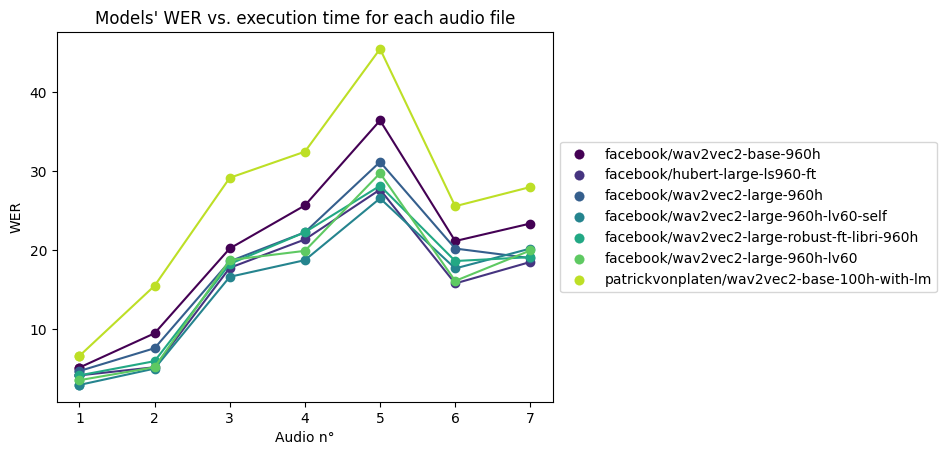

In [37]:
fig, ax = plt.subplots()

colormap = cm.viridis
colorlist = [colors.rgb2hex(colormap(i)) for i in np.linspace(0, 0.9, len(df['Model']))]

for i,c in enumerate(colorlist):

    x=1
    y = df['WER1'][i]
    l = df['Model'][i]
    
    x2=2
    y2 = df['WER2'][i]
    
    x3=3
    y3 = df['WER3'][i]
    
    x4=4
    y4 = df['WER4'][i]
    
    x5=5
    y5 = df['WER5'][i]
    
    x6=6
    y6 = df['WER6'][i]
    
    x7=7
    y7 = df['WER7'][i]
    
    plt.plot([x,x2,x3,x4,x5,x6,x7], [y,y2,y3,y4,y5,y6,y7], marker = 'o', c=c)
    
    # legend
    ax.scatter(x, y, label=l, s=50, linewidth=0.1, c=c)


# Display the legend on the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title("Models' WER vs. execution time for each audio file")
plt.xlabel("Audio n°")
plt.ylabel("WER")
plt.show()

On this graph, we can see that the evolution of the WER for audios are in phase, whatever the model used.

However, we note that the models `patrickvonplaten/wav2vec2-base-100h-with-lm` (yellow-green color) and `facebook/wav2vec2-base-960h` (purple) have more difficulty in performing their task qualitatively, since they get higher WER every time.

Also, this graph allows us to affirm that the models succeed in transcribing the same audios and encounter difficulties on the same ones.

We will now calculate the mean of the WERs, their median, and their standard deviation. We will do the same for the execution time, and we will calculate the new ratios obtained (Ratio of the means, of the medians, and of the standard deviations).

In [38]:
# Create lists to save the metrics
wer_mean_list = []
wer_median_list = [] 
wer_st_deviation_list = []
time_mean_list = []
time_median_list = [] 
time_st_deviation_list = []

# Locate each line of the DataFrame and calculate the mean, median, and standard division (std) of WER and execution time
number_of_models = len(df)
for i in range (number_of_models):
    # WER
    df_wer = df.loc[i, ['WER1','WER2','WER3', 'WER4', 'WER5', 'WER6', 'WER7']]
    wer_mean_list.append(round(df_wer.mean(),2))
    wer_median_list.append(round(df_wer.median(),2))
    wer_st_deviation_list.append(round(df_wer.std(),2))
    
    # Execution time
    df_time = df.loc[i, ['Time1','Time2','Time3', 'Time4', 'Time5', 'Time6', 'Time7']]
    time_mean_list.append(round(df_time.mean(),2))
    time_median_list.append(round(df_time.median(),2))
    time_st_deviation_list.append(round(df_time.std(),2))
    
# Create the DataFrame with a column equals to the names of the models
final_df = pd.DataFrame(data = models_names_list, columns=['Model'])

# Add Transcript & Execution time lists to our DataFrame
final_df = final_df.assign(Mean_WER=wer_mean_list, Median_WER=wer_median_list, Standard_deviation_WER=wer_st_deviation_list, Mean_time=time_mean_list, Median_time=time_median_list, Standard_deviation_time=time_st_deviation_list)

# Calculate new ratios of each type (ratio of the mean, of the median, and of the standard deviation)
final_df['Mean_Ratio'] = final_df['Mean_time']/final_df['Mean_WER']
final_df['Median_Ratio'] = final_df['Median_time']/final_df['Median_WER']
final_df['Standard_deviation__Ratio'] = final_df['Standard_deviation_time']/final_df['Standard_deviation_WER']

Our final DataFrame is ready to be displayed:

In [39]:
# Display data
display(final_df)

,Model,Mean_WER,Median_WER,Standard_deviation_WER,Mean_time,Median_time,Standard_deviation_time,Mean_Ratio,Median_Ratio,Standard_deviation__Ratio
0,facebook/wav2vec2-base-960h,20.19,21.14,10.38,1.98,1.02,2.56,0.098068,0.048250,0.246628
1,facebook/hubert-large-ls960-ft,15.76,17.75,8.48,2.11,1.74,1.11,0.133883,0.098028,0.130896
2,facebook/wav2vec2-large-960h,17.63,18.98,8.97,1.91,1.56,1.01,0.108338,0.082192,0.112598
3,facebook/wav2vec2-large-960h-lv60-self,15.38,17.67,8.46,2.10,1.71,1.10,0.136541,0.096774,0.130024
4,facebook/wav2vec2-large-robust-ft-libri-960h,16.63,18.61,8.64,2.12,1.71,1.16,0.127480,0.091886,0.134259
5,facebook/wav2vec2-large-960h-lv60,16.15,18.73,9.13,2.10,1.71,1.11,0.130031,0.091297,0.121577
6,patrickvonplaten/wav2vec2-base-100h-with-lm,26.10,27.98,12.40,0.84,0.70,0.44,0.032184,0.025018,0.035484


**A quick reminder of the definitions**:

- **The mean** is the numerical average of the data set.
- **The median** value is the middle one in a set of values arranged in order of size.
- **Standard Deviation** shows the variation in data. If the data is close together, the standard deviation will be small. If the data is spread out, the standard deviation will be large.

**Which one is the best model ?**

If we look at the performances obtained by each of the models, several conclusions can be made.

*⚠️ Predictions may vary and you may not have the same values as me.* 

**If we base ourselves on the transcript's quality (WER)**: 

The best model is the number 3, called *`facebook/wav2vec2-large-960h-lv60-self`*. 

Indeed, we see that this one obtains the best WER mean and median values `13.38` and `17.67`. Moreover, its standard deviation is `8.46`, which is also the best value obtained by all the models used. Therefore, the WERs obtained with this model are more constant than those of the other models. In this sense, this model is more reliable and is the best one. 

**If we base ourselves on the execution time**: 

In this case, we could say that the best model is the number 6, named *`patrickvonplaten/wav2vec2-base-100h-with-lm`*. 

It has the fastest transcription mean time `(0.84)`. Unfortunately, its transcription quality (WER) is highly impacted since it is the one with the worst results `(WER mean : 26.10)`. However, if we are looking for a fast model, this one is at the top of our list!

If you are looking for a model that is both correct in terms of quality and fast, perhaps model number 0 `facebook/wav2vec2-base-960h` and model number 2 `facebook/wav2vec2-large-960h` are more interesting. Like the 6th, they are quite fast and get a much better word error rate. These models will give you correct results in a short time.

**If we base ourselves on the ratio**:

Since this is a ratio, the values are closer here. This complicates the comparison. However, four models stand out here:

- N°1 : facebook/hubert-large-ls960-ft (Ranked #2)
- N°3 : facebook/wav2vec2-large-960h-lv60-self (Ranked #6)
- N°4 : facebook/wav2vec2-large-robust-ft-libri-960h (Ranked #3400)
- N°5 : facebook/wav2vec2-large-960h-lv60 (Ranked #436)

All these models are efficient in terms of time/quality. We could say that numbers 1 and 3 are the best models since they have the best Time/WER ratio. However, all these ratios are extremely close and the small difference between them does not allow us to identify the best model. Also, the scores obtained are questionable. Indeed, these models managed to transcribe the used audios correctly but maybe they would be less successful with others. Also, it is important to understand that each model will not give the same transcript every time for a same audio. In this sense, the WER varies and the comparison of models is less reliable. To sum up, comparing only 7 audios is not enough to conclude. 

In the end, the choice of the model depends solely on you. It depends on the importance you place on the quality of the transcript (WER) and the execution time ! 

Finally, we can confirm that the popularity rank of the models does not necessarily mean that they are performing well. Model number 4 has quite acceptable statistics and yet is ranked 3400th.

## Conclusion

To summarize, if you are not concerned about the time required to obtain the transcript, the study conducted recommends model number 3. 

If, on the other hand, you are more concerned about the time required without being overly concerned about the quality of the transcript, you should use model number 6 or 0. 

Finally, if you are concerned about the best time/quality ratio, you should choose one of the following models instead:
Number 3, 1, 5, 4.

⚠️ Keep in mind that this study cannot be taken literally. We have only tested these models on 7 different audios in order to get an idea of the performances. But this is not enough to build a real conclusion ! 

If you want more information, you can have a look at [this study](https://paperswithcode.com/sota/automatic-speech-recognition-on-librispeech-2) that compared the WER of many models on the Librispeech database. 

Note that **this study does not take into account the execution time of the models** ! 

I hope you have enjoyed this tutorial!

You are now capable of creating a transcript with a speaker differentiation (diarization) and a timestamped transcript to generate video's subtitles!

You can check our **next tutorials (blog format)** about speech to text to learn how to:

- [Build a complete speech to text application with Streamlit to make your code interactive](https://blog.ovhcloud.com/how-to-build-a-speech-to-text-application-with-python-1-3/)